# SMYLE & CLM5-TRENDY TWS perfect prediction skill
- SMYLE global maps code updated for CLM output 
- Here comparing SMYLE TWS with TRENDY initial condions 
- Will Wieder, Oct 9, 2021

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from distributed import wait

%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [62]:
cluster.close()
client.close()

In [10]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [11]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38522 instead
  warnings.warn(


In [12]:
cluster

- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [13]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [14]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    d0 = cal.time_set_midmonth(ds0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time']]
    d0 = d0.chunk({'L':-1})
    return d0

In [15]:
# SMYLE-NOV TWS data
# process all 20 ensemble members, all start dates dates from 1970-2018:
# these only need to be defined once, with io for each initialized month handled below
field = 'TWS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.clm2.h0.'
filetemplate = datadir+casename+'/lnd/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
print(filetemplate)
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
chunk = {}

/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.????-MM.EEE/lnd/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.????-MM.EEE.clm2.h0.TWS.*.nc


In [16]:
%%time
startmonth = 11
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
print('smyle11 data set = '+str(smyle11.nbytes/1e9)+ ' GB') #GB

smyle11 data set = 5.202259752 GB
CPU times: user 36.5 s, sys: 19.4 s, total: 55.9 s
Wall time: 1min 3s


In [17]:
%%time
# convert monthly data to seasonal data
smyle11 = cal.mon_to_seas_dask(smyle11).load()

CPU times: user 44 s, sys: 6.11 s, total: 50.1 s
Wall time: 52.5 s


In [18]:
%%time
# SMYLE-FEB TS data
# process all 20 ensemble members, Feb dates from 1970-2018:
startmonth = 2
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
print('smyle02 data set = '+str(smyle02.nbytes/1e9)+ ' GB') #GB

smyle02 data set = 5.202259752 GB
CPU times: user 40.7 s, sys: 20.2 s, total: 1min
Wall time: 1min 32s


In [19]:
%%time
# convert monthly data to seasonal data
smyle02 = cal.mon_to_seas_dask(smyle02).load()

CPU times: user 46.2 s, sys: 5.4 s, total: 51.6 s
Wall time: 53.4 s


In [20]:
%%time
# SMYLE-MAY TS data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
print('data set = '+str(smyle05.nbytes/1e9)+ ' GB') #GB

data set = 5.202259752 GB
CPU times: user 40.6 s, sys: 19.9 s, total: 1min
Wall time: 1min 30s


In [21]:
%%time
# convert monthly data to seasonal data
smyle05 = cal.mon_to_seas_dask(smyle05).load()

CPU times: user 48.5 s, sys: 5.39 s, total: 53.9 s
Wall time: 55.7 s


In [22]:
%%time
# SMYLE-AUG TS data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor,chunks=chunk)
print('smyle08 data set = '+str(smyle08.nbytes/1e9)+ ' GB') #GB

smyle08 data set = 5.202259752 GB
CPU times: user 40.8 s, sys: 19.9 s, total: 1min
Wall time: 1min 30s


In [23]:
%%time
# convert monthly data to seasonal data
smyle08 = cal.mon_to_seas_dask(smyle08).load()

CPU times: user 50.7 s, sys: 5.68 s, total: 56.4 s
Wall time: 57.7 s


### DataArrays are manageable size now (and in memory), so release Dask cluster 

In [24]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11.to_netcdf(outdir+'SMYLE11_TWS_seas.nc')
smyle02.to_netcdf(outdir+'SMYLE02_TWS_seas.nc')
smyle05.to_netcdf(outdir+'SMYLE05_TWS_seas.nc')
smyle08.to_netcdf(outdir+'SMYLE08_TWS_seas.nc')

CPU times: user 192 ms, sys: 3 s, total: 3.19 s
Wall time: 5.06 s


In [3]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11 = xr.open_dataset(outdir+'SMYLE11_TWS_seas.nc')
smyle02 = xr.open_dataset(outdir+'SMYLE02_TWS_seas.nc')
smyle05 = xr.open_dataset(outdir+'SMYLE05_TWS_seas.nc')
smyle08 = xr.open_dataset(outdir+'SMYLE08_TWS_seas.nc')
field = 'TWS'

### Get results from CLM5 SMYLE-TRENDY for potential predictability
/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/

In [4]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/'
fin = 'smyle_Transient.clm2.h0.'+field+'.185001-201812.nc'
#ds_clm = time_set_mid(xr.open_dataset(obs_dir+fin,decode_times=True),'time')
ds_clm = xr.open_dataset(obs_dir+fin,decode_times=False)
clm_montime_vals = [cftime.DatetimeNoLeap(1850+year, 1+month, 15) for year in range(169) for month in range(12)]
ds_clm['time'] = clm_montime_vals
ds_clm = ds_clm.sel(time=slice('1960','2018'))
ds_clm['time']

<xarray.DataArray 'time' (time: 708)>
array([cftime.DatetimeNoLeap(1960, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00

### Compute OBS seasonal averages

In [5]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [6]:
clm_seas = obs_convert_mon_to_seas(ds_clm.TWS,'TWS')

In [7]:
## convert OBS to anomalies from 1972-2017
clm_seas = clm_seas - clm_seas.sel(year=slice(1972,2018)).mean('year')

In [8]:
# Get rid of spurious 2019 values
clm_seas = clm_seas.sel(year=slice(1960,2018))
clm_seas

<xarray.Dataset>
Dimensions:  (year: 59, lon: 288, lat: 192, season: 4)
Coordinates:
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2014 2015 2016 2017 2018
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * season   (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    TWS      (season, year, lat, lon) float64 nan nan nan nan ... nan nan nan

# Anomaly Correlation Plots

In [9]:
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11,smyle11.time,1972,2018)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02,smyle02.time,1972,2018)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05,smyle05.time,1972,2018)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08,smyle08.time,1972,2018)

In [10]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_skill_byseas(mod_da,mod_time,obs_da,detrend=False):
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    e_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        e = xs.rmse(a,b,dim='time')/b.std('time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        e_list.append(e)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    rmse = xr.concat(e_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval,'rmse':rmse})

In [11]:
%%time
smyle11_skill = leadtime_skill_byseas(smyle11_anom[field].isel(Y=slice(0,-2)),smyle11.isel(Y=slice(0,-2)).time,clm_seas[field])
smyle02_skill = leadtime_skill_byseas(smyle02_anom[field].isel(Y=slice(0,-2)),smyle02.isel(Y=slice(0,-2)).time,clm_seas[field])
smyle05_skill = leadtime_skill_byseas(smyle05_anom[field].isel(Y=slice(0,-2)),smyle05.isel(Y=slice(0,-2)).time,clm_seas[field])
smyle08_skill = leadtime_skill_byseas(smyle08_anom[field].isel(Y=slice(0,-2)),smyle08.isel(Y=slice(0,-2)).time,clm_seas[field])

CPU times: user 12.7 s, sys: 4.64 s, total: 17.4 s
Wall time: 18.1 s


In [12]:
# Mask Antarctica
smyle11_skill = smyle11_skill.where(smyle11_skill.lat>-60.)
smyle02_skill = smyle02_skill.where(smyle02_skill.lat>-60.)
smyle05_skill = smyle05_skill.where(smyle05_skill.lat>-60.)
smyle08_skill = smyle08_skill.where(smyle08_skill.lat>-60.)

CPU times: user 11.5 s, sys: 71.6 ms, total: 11.6 s
Wall time: 12.1 s


''

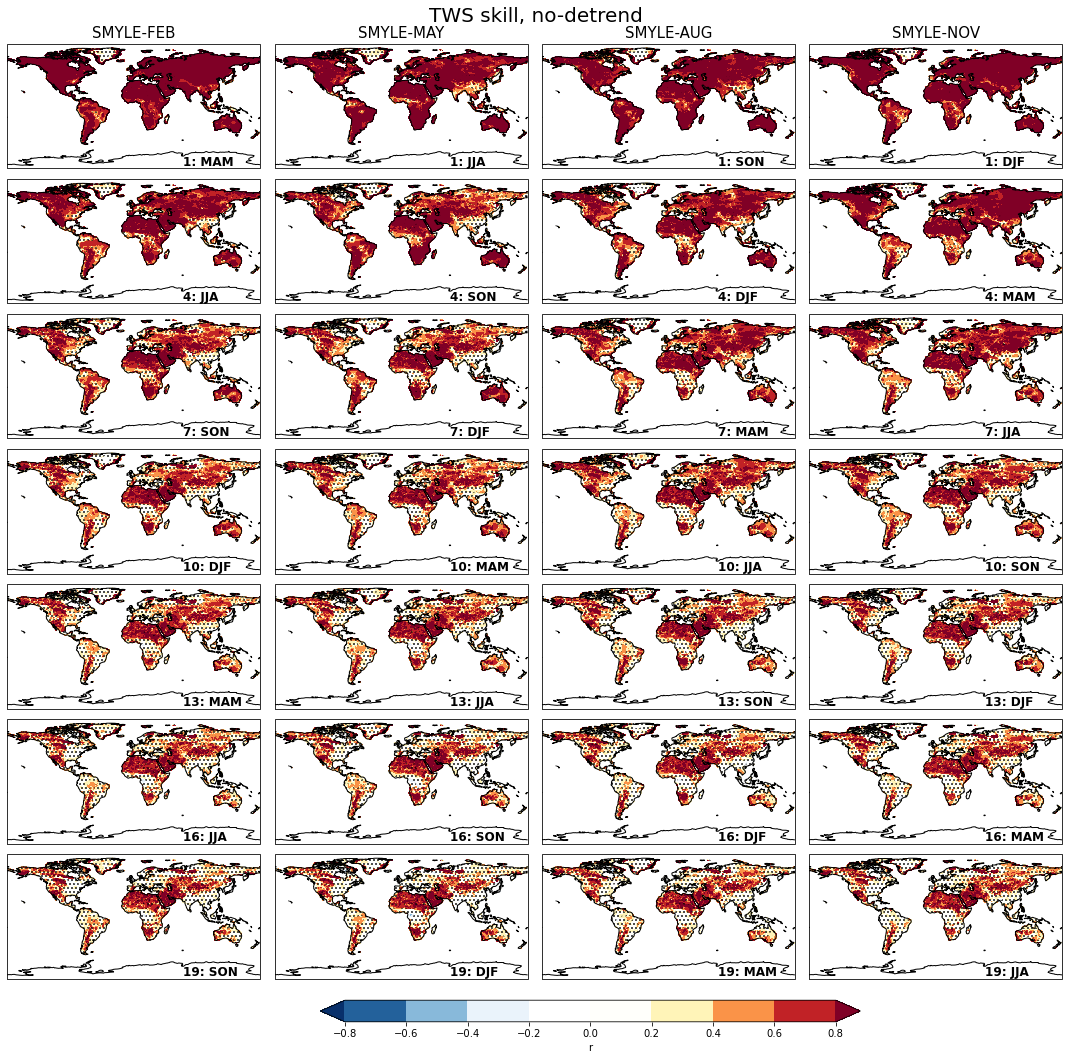

In [13]:
%%time
ci = 0.2
cmin = -0.8
cmax = 0.8
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(15,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*ncols+1,proj,extend='both')
    ax1.contourf(smyle02_skill.lon, smyle02_skill.lat,smyle02_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*ncols+2,proj,extend='both')
    ax2.contourf(smyle05_skill.lon, smyle05_skill.lat,smyle05_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*ncols+3,proj,extend='both')
    ax3.contourf(smyle08_skill.lon, smyle08_skill.lat,smyle08_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*ncols+4,proj,extend='both')
    ax4.contourf(smyle11_skill.lon, smyle11_skill.lat,smyle11_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle((field+' skill, no-detrend'),fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal') 

### Test Significance Hatching using correlation p-values

CPU times: user 374 ms, sys: 2.38 ms, total: 376 ms
Wall time: 396 ms


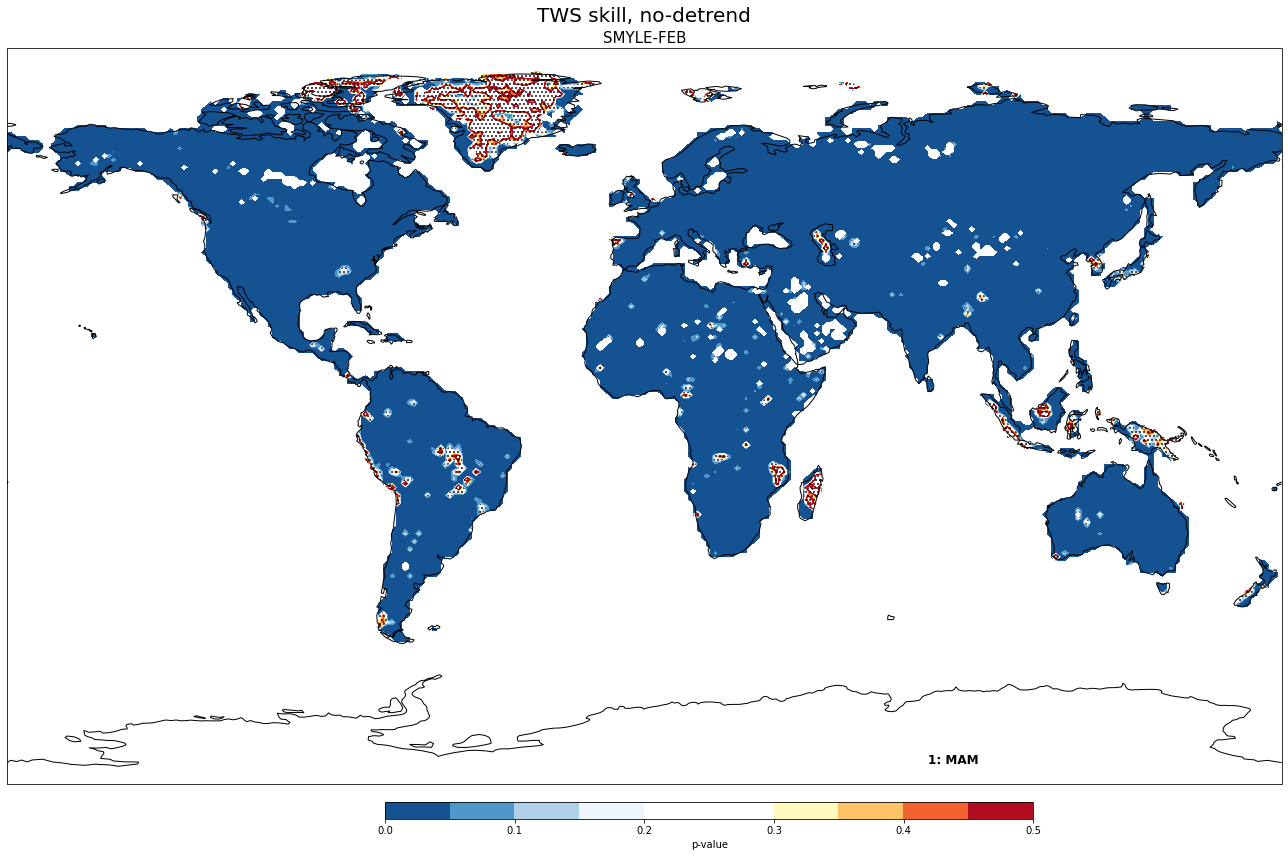

In [14]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,12))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_skill.pval.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*4+1,proj)
    ax1.contourf(smyle02_skill.lon, smyle02_skill.lat,smyle02_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...','...'], alpha=0.)
    ldstr = str(i+1) + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle(field+' skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [15]:
%%time
smyle11_skill = leadtime_skill_byseas(smyle11_anom[field],smyle11.time,clm_seas[field],detrend=True)
smyle02_skill = leadtime_skill_byseas(smyle02_anom[field],smyle02.time,clm_seas[field],detrend=True)
smyle05_skill = leadtime_skill_byseas(smyle05_anom[field],smyle05.time,clm_seas[field],detrend=True)
smyle08_skill = leadtime_skill_byseas(smyle08_anom[field],smyle08.time,clm_seas[field],detrend=True)
smyle11_skill = smyle11_skill.where(smyle11_skill.lat>-60.)
smyle02_skill = smyle02_skill.where(smyle02_skill.lat>-60.)
smyle05_skill = smyle05_skill.where(smyle05_skill.lat>-60.)
smyle08_skill = smyle08_skill.where(smyle08_skill.lat>-60.)

CPU times: user 43.3 s, sys: 5.63 s, total: 48.9 s
Wall time: 51.5 s


CPU times: user 38.7 s, sys: 55.9 ms, total: 38.7 s
Wall time: 40.1 s


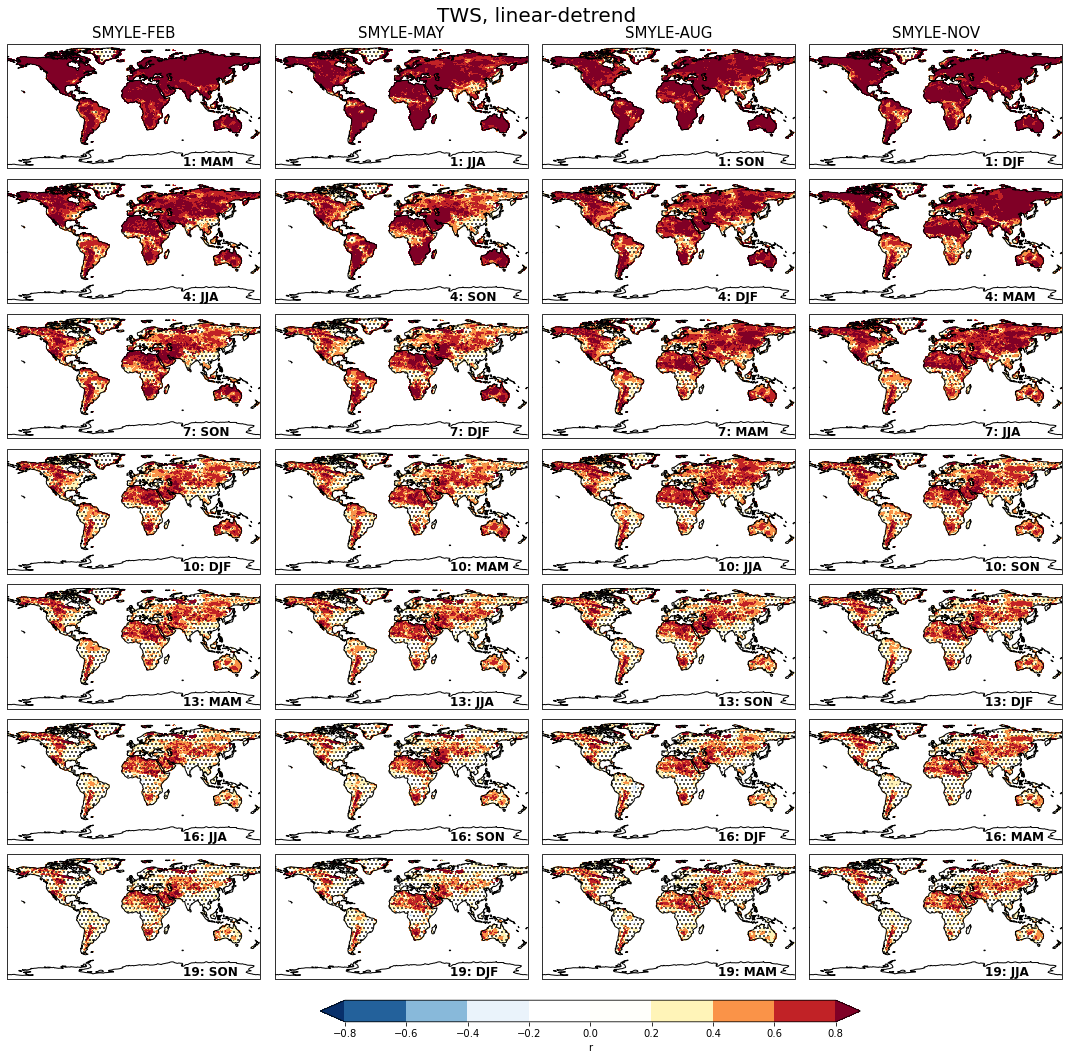

In [16]:
%%time
ci = 0.2
cmin = -0.8
cmax = 0.8
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(15,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_skill.corr.isel(L=i), smyle02_skill.lon, smyle02_skill.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*ncols+1,proj,extend='both')
    ax1.contourf(smyle02_skill.lon, smyle02_skill.lat,smyle02_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_skill.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_skill.corr.isel(L=i), smyle05_skill.lon, smyle05_skill.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*ncols+2,proj,extend='both')
    ax2.contourf(smyle05_skill.lon, smyle05_skill.lat,smyle05_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_skill.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_skill.corr.isel(L=i), smyle08_skill.lon, smyle08_skill.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*ncols+3,proj,extend='both')
    ax3.contourf(smyle08_skill.lon, smyle08_skill.lat,smyle08_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_skill.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_skill.corr.isel(L=i), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*ncols+4,proj,extend='both')
    ax4.contourf(smyle11_skill.lon, smyle11_skill.lat,smyle11_skill.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_skill.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle(field+', linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_'+field+'.png')

## Focus on high JJA skill over Southwest CONUS

CPU times: user 752 ms, sys: 6.09 ms, total: 758 ms
Wall time: 772 ms


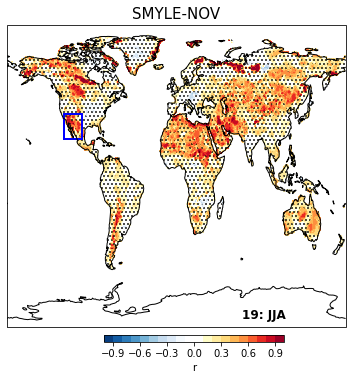

In [17]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(5,5))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_skill.corr.isel(L=6), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,1,1,1,proj)
ax4.contourf(smyle11_skill.lon, smyle11_skill.lat,smyle11_skill.pval.isel(L=6), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
ax4.add_patch(mpatches.Rectangle(xy=[-120, 22], width=20, height=15,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))

fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr4, cax=cbar_ax, label='r', orientation='horizontal')

In [20]:
# SW regional-average
region1lonlat = [-120.,-100.,22.,37.]  
region1title = 'SW'

tmp = clm_seas[field].sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
trendy_tws = tmp.weighted(wgts).mean(("lon", "lat"))
trendy_raw_tws = ds_clm[field].sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1])).weighted(wgts).mean(("lon", "lat"))

tmp = smyle11_anom.isel(L=6).mean('M').sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
smyle_tws = tmp.weighted(wgts).mean(("lon", "lat")).rename({'Y':'time'})
smyle_tws = smyle_tws['TWS']
smyle_tws['time'] = smyle11.isel(L=6).time.dt.year.values

In [57]:
ds_clm

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levlak: 10, levdcmp: 25, lon: 288, lat: 192, time: 708, hist_interval: 2)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time          (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00
Dimensions without coordinates: hist_interval
Data variables: (12/22)
    area          (lat, lon) float32 ...
    landfrac      (lat, lon) float32 ...
    landmask      (lat, lon) float64 ...
    pftmask       (lat, lon) float64 ...
    nbedrock      (lat, lon) float64 ...
    ZSOI          (levgrnd, lat, lon) float32 ...
    ...            ...
    mscur         (time) float64 ...
    nstep         (time) float64 ...
    time_bounds   (time, hist_interval) float64 ...
    date_written  (time) object ...
    time_written  (time) object ...
    TWS           (time, lat, lon) float32 ...
Attributes: (12/100)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 12/15/20 17:18:15
    source:                                    Community Land Model CLM4.0
    hostname:                                  cheyenne
    ...                                        ...
    cft_irrigated_switchgrass:                 60
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1

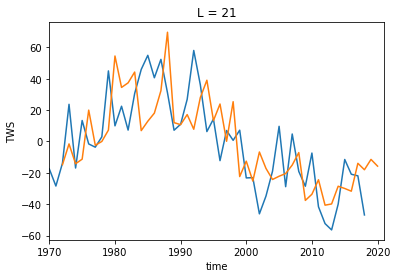

In [19]:
trendy_tws.sel(season='JJA').plot(xlim=[1970,2021]);
smyle_tws.plot()

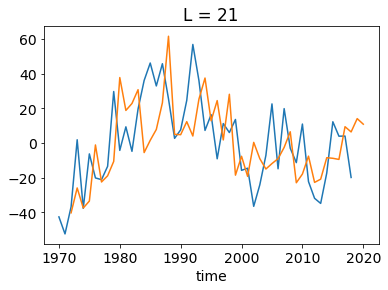

In [42]:
detrend_linear(trendy_tws.sel(season='JJA').sel(year=slice(1970,2021)),'year').plot();
detrend_linear(smyle_tws.sel(time=slice(1970,2021)),'time').plot();

In [49]:
a = detrend_linear(trendy_tws.sel(season='JJA').rename({'year':'time'}),'time')
b = detrend_linear(smyle_tws,'time')
a,b = xr.align(a,b)
xr.corr(a,b)

<xarray.DataArray ()>
array(0.41282615)
Coordinates:
    season   <U3 'JJA'
    L        int64 21

In [48]:
a

<xarray.DataArray 'TWS' (time: 47)>
array([-13.85783551,  23.73021187, -16.9250239 ,  13.39826263,
        -1.56766435,  -3.62805088,   2.97336799,  45.04397307,
         9.9876855 ,  22.49962074,   7.27147987,  30.61589612,
        45.99470642,  54.98332113,  40.66732467,  52.4046756 ,
        31.06985226,   7.17245114,  11.00262658,  26.90208178,
        58.09128861,  36.22135324,   6.32310446,  14.33077524,
       -12.22667732,   7.01141687,   0.7339484 ,   7.21012253,
       -23.24409981, -23.08427778, -46.17265813, -34.86037493,
       -18.95879304,   9.67383798, -28.84770747,   4.77519109,
       -19.1313317 , -28.55520546,  -7.38514333, -41.66844671,
       -52.40138316, -56.43348902, -39.96041658, -11.48224828,
       -20.90440142, -21.91001079, -46.88333622])
Coordinates:
  * time     (time) int64 1972 1973 1974 1975 1976 ... 2014 2015 2016 2017 2018
    season   <U3 'JJA'

In [ ]:
%%time
smyle11_reg = smyle11_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle11_reg = smyle11_reg.weighted(wgts).mean(("lon", "lat"))
smyle02_reg = smyle02_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle02_reg = smyle02_reg.weighted(wgts).mean(("lon", "lat"))
smyle05_reg = smyle05_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle05_reg = smyle05_reg.weighted(wgts).mean(("lon", "lat"))
smyle08_reg = smyle08_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle08_reg = smyle08_reg.weighted(wgts).mean(("lon", "lat"))

CPU times: user 129 ms, sys: 4.08 ms, total: 133 ms
Wall time: 137 ms


In [22]:
%%time
smyle11_skill_reg = leadtime_skill_byseas(smyle11_reg[field],smyle11.time,trendy_tws,detrend=True)
smyle02_skill_reg = leadtime_skill_byseas(smyle02_reg[field],smyle02.time,trendy_tws,detrend=True)
smyle05_skill_reg = leadtime_skill_byseas(smyle05_reg[field],smyle05.time,trendy_tws,detrend=True)
smyle08_skill_reg = leadtime_skill_byseas(smyle08_reg[field],smyle08.time,trendy_tws,detrend=True)

CPU times: user 433 ms, sys: 165 µs, total: 433 ms
Wall time: 453 ms


(0.2, 1.5)

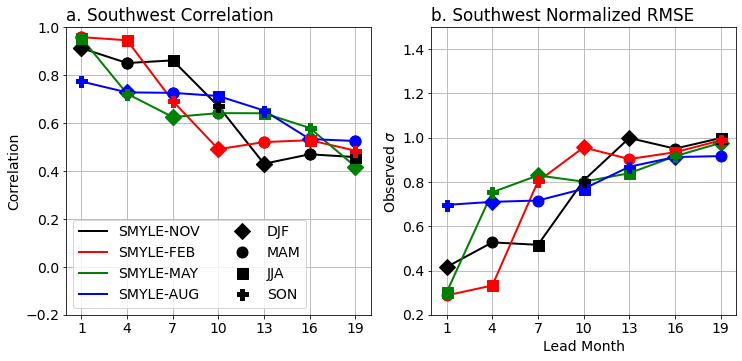

In [23]:
# plot correlation
fig = plt.figure(figsize=(12,18))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill_reg.L-2
seasons = ['DJF','MAM','JJA','SON']
markers = ['D','o','s','P']
regiontitle = 'Southwest'

ncol = 2
nrow = 3

ax = fig.add_subplot(3,2,1)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_title('a. {} Correlation'.format(regiontitle),loc='left')
ax.plot(leadmon,smyle11_skill_reg.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_skill_reg.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_skill_reg.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_skill_reg.corr,color='b',linewidth=2,label='SMYLE-AUG')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season==i).where(smyle11_skill_reg.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season==i).where(smyle02_skill_reg.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season==i).where(smyle05_skill_reg.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season==i).where(smyle08_skill_reg.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([0,20])
ax.set_ylim([-0.2,1])

ax = fig.add_subplot(3,2,2)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. {} Normalized RMSE'.format(regiontitle),loc='left')
ax.plot(leadmon,smyle11_skill_reg.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_skill_reg.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_skill_reg.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_skill_reg.rmse,color='b',linewidth=2)
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill_reg.rmse.where(smyle11_skill_reg.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_skill_reg.rmse.where(smyle02_skill_reg.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill_reg.rmse.where(smyle05_skill_reg.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill_reg.rmse.where(smyle08_skill_reg.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([0,20])
ax.set_ylim([0.2,1.5])

### Create Persistence scores from autocorrelation of smoothed Trendy data

##### Method 1:  Compute autocorrelations of 3-month running mean monthly data with lead month lags matching SMYLE hindcasts

In [50]:
trendy_raw_tws.sel(time=slice("1970","2019")).time

<xarray.DataArray 'time' (time: 588)>
array([cftime.DatetimeNoLeap(1970, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1970-01-15 00:00:00 ... 2018-12-15 00:00:00

In [51]:
trendy_3mrunmean = trendy_raw_tws.rolling(time=3, center=True).mean().sel(time=slice("1970","2019"))
#trendy_3mrunmean.plot()
trendy_3mrunmean_dt = detrend_linear(trendy_3mrunmean, 'time')

nl = 7
tshift = [3,6,9,12,15,18,21]
clist = []
for i in range(nl):
    tmp = trendy_3mrunmean_dt.shift(time=tshift[i])
    corr = xs.pearson_r(trendy_3mrunmean_dt,tmp,'time',skipna=True)
    clist.append(corr)
pers_skill = xr.concat(clist,dim=smyle11_skill.isel(L=slice(0,7)).L)

##### Method 2:  Compute lag-1 and lag-2 autocorrelations of JJA data

In [52]:
trendy_jja_dt =  trendy_3mrunmean_dt.where(trendy_3mrunmean_dt.time.dt.month==7).dropna('time')
trendy_jja_ac1 = xs.pearson_r(trendy_jja_dt,trendy_jja_dt.shift(time=1),'time',skipna=True)
trendy_jja_ac2 = xs.pearson_r(trendy_jja_dt,trendy_jja_dt.shift(time=2),'time',skipna=True)

In [53]:
trendy_jja_ac1,trendy_jja_ac2

(<xarray.DataArray ()>
 array(0.59915002),
 <xarray.DataArray ()>
 array(0.4696244))

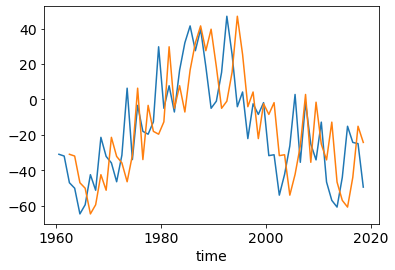

In [41]:
trendy_jja_dt.plot()
trendy_jja_dt.shift(time=2).plot()

CPU times: user 1.58 s, sys: 101 ms, total: 1.68 s
Wall time: 1.73 s


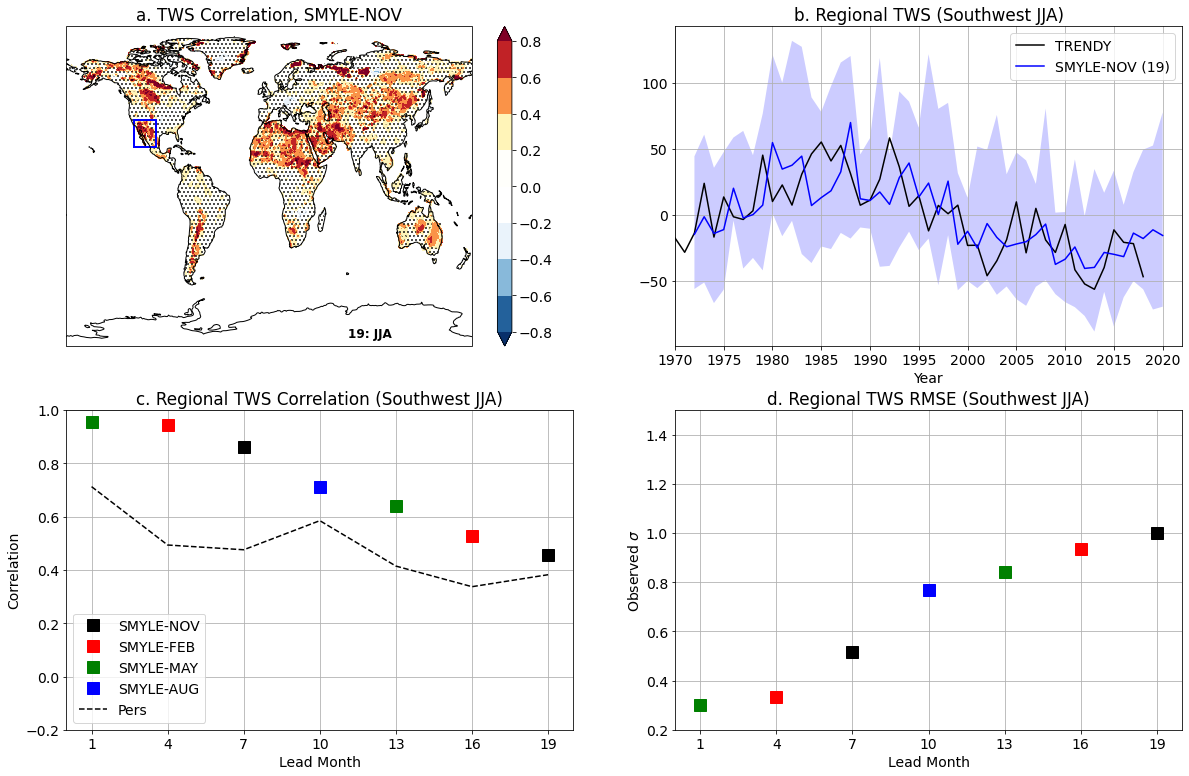

In [54]:
%%time
import matplotlib.patches as mpatches
ci = 0.2
cmin = -0.8
cmax = 0.8
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(20,20))
nrows=2
ncols=2

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle11_skill.corr.isel(L=6), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrow,ncol,1,proj,extend='both')
ax1.contourf(smyle11_skill.lon, smyle11_skill.lat,smyle11_skill.pval.isel(L=6), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
ax1.add_patch(mpatches.Rectangle(xy=[-120, 22], width=20, height=15,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))
ax1.set_title('a. TWS Correlation, SMYLE-NOV',loc='center')
fig.colorbar(cntr1, ax=ax1, label='')

ax2 = fig.add_subplot(nrow,ncol,2)
ax2.plot(trendy_tws.year,trendy_tws.sel(season='JJA'),color='k',label='TRENDY')
smyle11_time = smyle11.isel(L=6).time.dt.year.values
ax2.plot(smyle11_time,smyle11_reg['TWS'].mean('M').isel(L=6),color='b',label='SMYLE-NOV (19)')
ymin = smyle11_reg['TWS'].min('M').isel(L=6)
ymax = smyle11_reg['TWS'].max('M').isel(L=6)
ax2.fill_between(smyle11_time,ymin,ymax,fc='b',alpha=0.2)
ax2.legend(loc='upper right')
ax2.set_xticks(np.arange(1970,2025,5))
ax2.grid(True)
ax2.set_xlim([1970,2022])
ax2.set_title('b. Regional TWS (Southwest JJA)',loc='center')
ax2.set_xlabel('Year')
#ax2.set_ylim([-0.2,1])

ax3 = fig.add_subplot(nrow,ncol,3)
leadmon = smyle11_skill_reg.L-2
seasons = ['DJF','MAM','JJA','SON']
markers = ['D','o','s','P']
ax3.set_ylabel('Correlation', fontsize=14)
ax3.set_title('c. Regional TWS Correlation (Southwest JJA)',loc='center')
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season=='JJA'),color='k',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_skill_reg.season=='JJA').where(smyle11_skill_reg.pval<0.1),color='k',marker='s',ms=12,label='SMYLE-NOV',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season=='JJA'),color='r',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_skill_reg.season=='JJA').where(smyle02_skill_reg.pval<0.1),color='r',marker='s',ms=12,label='SMYLE-FEB',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season=='JJA'),color='g',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_skill_reg.season=='JJA').where(smyle05_skill_reg.pval<0.1),color='g',marker='s',ms=12,label='SMYLE-MAY',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season=='JJA'),color='b',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_skill_reg.season=='JJA').where(smyle08_skill_reg.pval<0.1),color='b',marker='s',ms=12,label='SMYLE-AUG',linestyle='none')
ax3.plot(leadmon[0:7],pers_skill,color='k',linestyle='dashed',label='Pers')
#ax3.plot([1,10],[trendy_jja_ac1,trendy_jja_ac1],color='k',linestyle='dashed',label='Pers')
#ax3.plot([13,19],[trendy_jja_ac2,trendy_jja_ac2],color='k',linestyle='dashed')
ax3.legend(loc='lower left',ncol=1)
ax3.set_xticks(leadmon)
ax3.grid(True)
ax3.set_xlim([0,20])
ax3.set_ylim([-0.2,1])
ax3.set_xlabel('Lead Month')

ax4 = fig.add_subplot(nrow,ncol,4)
ax4.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax4.set_title('d. Regional TWS RMSE (Southwest JJA)',loc='center')
ax4.plot(leadmon,smyle11_skill_reg.rmse.where(smyle11_skill_reg.season=='JJA'),color='k',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle02_skill_reg.rmse.where(smyle02_skill_reg.season=='JJA'),color='r',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle05_skill_reg.rmse.where(smyle05_skill_reg.season=='JJA'),color='g',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle08_skill_reg.rmse.where(smyle08_skill_reg.season=='JJA'),color='b',marker='s',ms=12,linestyle='none')
ax4.set_xticks(leadmon)
ax4.grid(True)
ax4.set_xlim([0,20])
ax4.set_ylim([0.2,1.5])
ax4.set_xlabel('Lead Month')

plt.savefig('TWSskill_Southwest_JJA.png')